### **Figure 5: T1w/T2w MIND network edges and nodal degrees predict age more accurately than regional mean T1w/T2w**

Results of age prediction are provided

If using these, 5.2 does not need to be run

#### **5.1 Setup**

In [5]:
# Autoreload
%load_ext autoreload
%autoreload 2

# Import helper functions
import sys
sys.path.append('code')
from stats_helpers import *
from plotting_helpers import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### **5.1 Plot correlations between age-binned networks**

To qualitatively assess whether networks show age-related changes, average networks into 4-month age bins, then cross-correlate the binned networks

Start by loading outlier-filtered data and retain developmental subset below 3 years

In [6]:
mean_t12_per_subj_df_filt = pd.read_csv('output/subj_dfs/mean_t12_per_subj_filt.csv', index_col=0)
mean_t12_dev = mean_t12_per_subj_df_filt[mean_t12_per_subj_df_filt['Age'] < 3]

degree_per_subj_df_filt = pd.read_csv('output/subj_dfs/degree_per_subj_filt.csv', index_col=0)
degree_dev = degree_per_subj_df_filt[degree_per_subj_df_filt['Age'] < 3]

edge_per_subj_df_filt = pd.read_csv('output/subj_dfs/edge_per_subj_filt.csv', index_col=0)
edge_dev = edge_per_subj_df_filt[edge_per_subj_df_filt['Age'] < 3]

covariate_per_subj_df_filt = pd.read_csv('output/subj_dfs/covariate_per_subj_filt.csv', index_col=0)
covariate_dev = covariate_per_subj_df_filt[covariate_per_subj_df_filt['Age'] < 3]
covariate_dev = covariate_dev.reindex(edge_dev.index)

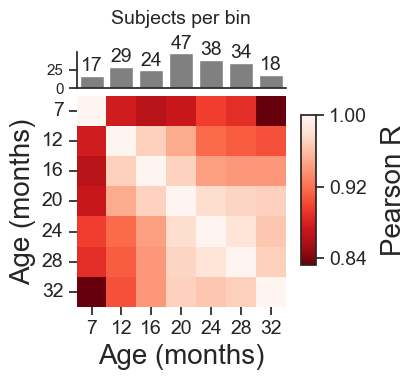

In [7]:
# Define age bin limits (4-month bins starting at 8 months)
age_bins = np.arange(8/12,3.25,4/12)

# Use plotting helper function
age_bin_correlations(edge_per_subj_df_filt, age_bins, cbar_min=0.84)

#### **5.2  Use machine learning models to predict age from MRI features**

The following code predicts subject age using their vector of mean T1w/T2w values, MIND degrees, or MIND edges:
1. The dataset is split into a training and test set (80:20), balanced for sex. 50 distinct splits of the data are obtained
2. Within each outer training set, 5-fold cross-validation (80:20, again balanced for sex) is used to train models on support vector regression models and a GPR model
3. The best performing model across the 5-folds is trained on the entire training set, and validated against the test set, giving performance for that fold
4. Results across all folds and within an median-performing fold are plotted

Define outer train/test split using repeated stratified K-Fold cross validation

In [5]:
# Dummy subject dataframe
dummy_X = np.zeros(mean_t12_dev.shape[0]).reshape(-1, 1)

# Define repeated stratified K-Fold
n_splits = 5; n_repeats = 10 # 5 splits of the data repeated 10 times yields 50 unique folds
rskf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=270900)

# Initialise dictionary to hold train/test indices per outer fold
outer_split_dict = {}

for i, (train_index, test_index) in enumerate(rskf.split(dummy_X, mean_t12_dev['Sex']), start=1):
    outer_split_dict[i] = {"train": list(train_index), "test": list(test_index)}

Create a pipeline to automatically cycle through 5 models: 
- Support vector regressions with radial basis function kernel and C regularisation values of [0.1, 1, 10, 100]
- A gaussian process regression with summed linear and white noise kernel and alpha value of 1e-10 

... for each predictor (mean T1w/T2w, degree, and edges)

In [6]:
# Initialise data and pipeline

pipe = Pipeline([
    ('model', None),
])

init_dict = {
    'mean t12': {
        'df':mean_t12_dev,
        'param_grid': [
            {
                'model': [SVR()],
                'model__C': [0.1, 1, 10, 100],
                'model__gamma': ['scale'],
                'model__kernel': ['rbf']
            },
            {
                'model': [GaussianProcessRegressor()],
                'model__kernel': [DotProduct() + WhiteKernel(noise_level_bounds=(1e-10, np.inf))]
            }
        ]
    },
    'degree': {
        'df':degree_dev,
        'param_grid': [
            {
                'model': [SVR()],
                'model__C': [0.1, 1, 10, 100],
                'model__gamma': ['scale'],
                'model__kernel': ['rbf']
            },
            {
                'model': [GaussianProcessRegressor()],
                'model__kernel': [DotProduct() + WhiteKernel(noise_level_bounds=(1e-10, np.inf))]
            }
        ]
    },
    'edge': {
        'df':edge_dev,
        'param_grid': [
            {
                'model': [GaussianProcessRegressor()],
                'model__kernel': [DotProduct() + WhiteKernel(noise_level_bounds=(1e-10, np.inf))]
            }
        ]
    },
}

Using this pipeline, initialise dataframes to hold:
- The performance of each model in each fold, operationalised as the average mean absolute error across 5 internal folds (all_models_performance_df)
- The partial r and mean absolute error between predicted and actual ages for the best model in each fold (best_models_performance_df)

In [7]:
all_dfs = []

for predictor in list(init_dict.keys()):
    params_df = pd.DataFrame(list(ParameterGrid(init_dict[predictor]['param_grid'])))
    params_df = pd.concat([
        pd.DataFrame({'predictor':[predictor]*params_df.shape[0]}),
        params_df
    ],axis=1)

    all_dfs.append(params_df)

all_models_df = pd.concat(all_dfs, ignore_index=True)
all_models_performance_df = pd.concat([
    all_models_df,
    pd.DataFrame(np.zeros((all_models_df.shape[0], n_splits*n_repeats)), columns=range(1, n_splits*n_repeats+1))
], axis=1)

best_models_performance_df = pd.DataFrame({
    'predictor': sum([[predictor] * (n_splits * n_repeats) for predictor in init_dict.keys()], []),
    'fold': list(range(1, n_splits * n_repeats + 1)) * len(init_dict),
    'mae': np.zeros(n_splits * n_repeats * len(init_dict)),
    'partial_r': np.zeros(n_splits * n_repeats * len(init_dict))
})

Loop through each predictor in init_df, train and evalutate the models, then store results

In [ ]:
# Initialise directory to hold results
output_dir = 'output/age_prediction_results/'
os.makedirs(output_dir, exist_ok=True)

for predictor in list(init_dict.keys()):
    # Get predictor df
    df = init_dict[predictor]['df'].copy()
    
    # Get inputs
    X = df.iloc[:, 4:]
    y = df['Age'].copy()

    # Outer loop
    for fold in tqdm(outer_split_dict.keys()):        
        # Split outer data
        train_index = outer_split_dict[fold]['train']
        test_index = outer_split_dict[fold]['test']
        
        X_train_outer, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train_outer, y_test = y.iloc[train_index], y.iloc[test_index]
        covar_train_outer, covar_test = covariate_dev.iloc[train_index], covariate_dev.iloc[test_index]
        
        # Scale data
        scaler = preprocessing.StandardScaler().fit(X_train_outer)
        X_train_outer_scaled = scaler.transform(X_train_outer)
        X_test_scaled = scaler.transform(X_test)

        # Inner loop

        # Generate inner train/test indices
        y_inner_cv = covar_train_outer['Sex'].values
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=270900).split(X=np.zeros_like(y_inner_cv), y=y_inner_cv)

        # Use GridSearchCV to search over the hyperparameters
        optimal_params = GridSearchCV(
                pipe, 
                init_dict[predictor]['param_grid'],
                cv=inner_cv,
                scoring='neg_mean_absolute_error',
                verbose=0 #2 for output on each model being cross validated
            )
        
        # Fit GridSearchCV
        optimal_params.fit(X_train_outer_scaled, y_train_outer)
        best_model = optimal_params.best_estimator_

        # Append mean MSE across internal folds for each model
        all_models_performance_df.loc[
            all_models_performance_df['predictor'] == predictor,
            fold
        ] = -optimal_params.cv_results_['mean_test_score']
        
        # Evaluate best model on outer test set
        y_pred = best_model.predict(X_test_scaled)
        mae = mean_absolute_error(y_test, y_pred)
        
        eval_df = pd.DataFrame({
            'test':y_test,
            'pred':y_pred,
            'sex':covar_test['Sex'],
            'etiv':covar_test['etiv']
        })
        
        partial_r = pg.partial_corr(data=eval_df, 
                                    x='test', 
                                    y='pred', 
                                    covar=['sex', 'etiv'],
                                    method='spearman').iloc[0,1]
        
        # Append
        best_models_performance_df.loc[
            (best_models_performance_df['predictor'] == predictor) &
            (best_models_performance_df['fold'] == fold),
             'mae'
        ] = mae

        best_models_performance_df.loc[
            (best_models_performance_df['predictor'] == predictor) &
            (best_models_performance_df['fold'] == fold),
             'partial_r'
        ] = partial_r

# Save model performance
all_models_performance_df.to_csv(os.path.join(output_dir, 'all_models_performance_df.csv'))
best_models_performance_df.to_csv(os.path.join(output_dir, 'best_models_performance_df.csv'))

#### **5.3  Visualise results**

Import and plot results

In [2]:
# Import results
output_dir = 'output/age_prediction_results/'

best_models_performance_df = pd.read_csv(os.path.join(output_dir, 'best_models_performance_df.csv'), index_col=0)
best_models_performance_df['mae'] = best_models_performance_df['mae']*12 # Convert from years to months for plotting

all_models_performance_df = pd.read_csv(os.path.join(output_dir, 'all_models_performance_df.csv'), index_col=0)

Plot performance across 50 folds

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

mean t12 vs. degree: Wilcoxon test (paired samples) with Bonferroni correction, P_val:2.418e-10 Stat=5.300e+01
degree vs. edge: Wilcoxon test (paired samples) with Bonferroni correction, P_val:6.084e-04 Stat=2.650e+02
mean t12 vs. edge: Wilcoxon test (paired samples) with Bonferroni correction, P_val:2.665e-14 Stat=3.000e+00


/var/folders/_0/khf_d2y950q8x7b5c90znmhw0000gn/T/ipykernel_46652/2611464240.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


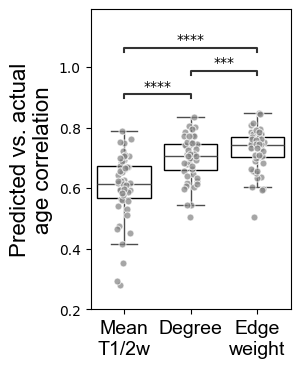

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

mean t12 vs. degree: Wilcoxon test (paired samples) with Bonferroni correction, P_val:4.977e-01 Stat=4.930e+02
degree vs. edge: Wilcoxon test (paired samples) with Bonferroni correction, P_val:3.730e-14 Stat=4.000e+00
mean t12 vs. edge: Wilcoxon test (paired samples) with Bonferroni correction, P_val:2.665e-14 Stat=3.000e+00


/var/folders/_0/khf_d2y950q8x7b5c90znmhw0000gn/T/ipykernel_46652/2611464240.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


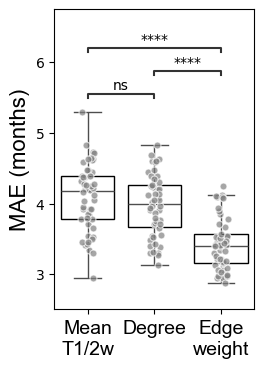

In [3]:
from statannotations.Annotator import Annotator
from matplotlib.ticker import MaxNLocator

for y_to_plot in ['partial_r', 'mae']:

    # Set x and y
    x = 'predictor'
    y = y_to_plot
    order = ['mean t12', 'degree', 'edge']

    # Define pairs to compare
    pairs = [
        ('mean t12', 'degree'),
        ('mean t12', 'edge'),
        ('degree', 'edge')
    ]

    palette = ['grey','grey','grey']

    # Plot
    fig = plt.figure(figsize=(2, 3))
    ax = fig.add_axes([0, 0, 1, 1])
    ax = sns.boxplot(data=best_models_performance_df, x=x, y=y, hue=x, order=order, palette=palette, showfliers=False,
                    boxprops={'facecolor': 'white', 'edgecolor': 'black'})
    sns.stripplot(data=best_models_performance_df, x=x, y=y, order=order, color='grey', edgecolor='white', linewidth=0.8, dodge=False, size=5, alpha=0.7, ax=ax)

    # Add statistical annotations
    annot = Annotator(ax, pairs, data=best_models_performance_df, x=x, y=y, order=order)
    annot.configure(test='Wilcoxon', text_format='star', comparisons_correction='Bonferroni', loc='outside')
    annot.apply_and_annotate()

    # Labelling
    plt.xlabel('')
    plt.xticks(ticks = [0, 1, 2], labels=['Mean\nT1/2w', 'Degree', 'Edge\nweight'],fontsize=14, fontfamily='Arial')
    
    if y_to_plot == 'partial_r':
        plt.ylim([0.2, 1.19])
        plt.ylabel('Predicted vs. actual\nage correlation', fontsize=16, fontfamily='Arial')
    elif y_to_plot == 'mae':
        plt.ylim([2.5, 6.75])
        plt.ylabel('MAE (months)', fontsize=16, fontfamily='Arial')
        ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
    plt.tight_layout()
    plt.show()


Plot performance of models with partial correlation closest to median (average model)

First, define identical outer train/test split using repeated stratified K-Fold cross validation

In [9]:
# Dummy subject dataframe
dummy_X = np.zeros(mean_t12_dev.shape[0]).reshape(-1, 1)

# Define repeated stratified K-Fold
n_splits = 5; n_repeats = 10 # 5 splits of the data repeated 10 times yields 50 unique folds
rskf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=270900)

# Initialise dictionary to hold train/test indices per outer fold
outer_split_dict = {}

for i, (train_index, test_index) in enumerate(rskf.split(dummy_X, mean_t12_dev['Sex']), start=1):
    outer_split_dict[i] = {"train": list(train_index), "test": list(test_index)}

/var/folders/_0/khf_d2y950q8x7b5c90znmhw0000gn/T/ipykernel_46652/580550446.py:88: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels([f"{t * 12:.0f}" for t in ticks], fontsize=14)
/var/folders/_0/khf_d2y950q8x7b5c90znmhw0000gn/T/ipykernel_46652/580550446.py:89: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([f"{t * 12:.0f}" for t in ticks], fontsize=14)


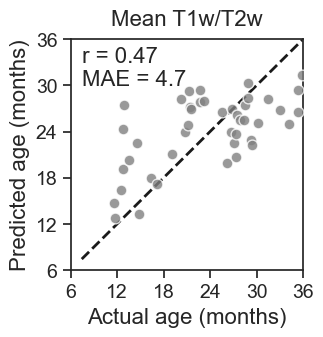

/var/folders/_0/khf_d2y950q8x7b5c90znmhw0000gn/T/ipykernel_46652/580550446.py:88: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels([f"{t * 12:.0f}" for t in ticks], fontsize=14)
/var/folders/_0/khf_d2y950q8x7b5c90znmhw0000gn/T/ipykernel_46652/580550446.py:89: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([f"{t * 12:.0f}" for t in ticks], fontsize=14)


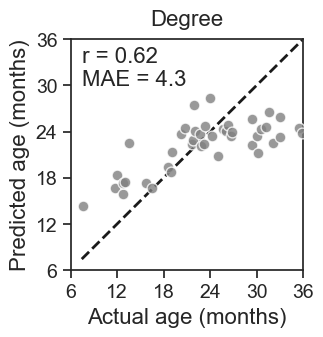

/var/folders/_0/khf_d2y950q8x7b5c90znmhw0000gn/T/ipykernel_46652/580550446.py:88: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels([f"{t * 12:.0f}" for t in ticks], fontsize=14)
/var/folders/_0/khf_d2y950q8x7b5c90znmhw0000gn/T/ipykernel_46652/580550446.py:89: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([f"{t * 12:.0f}" for t in ticks], fontsize=14)


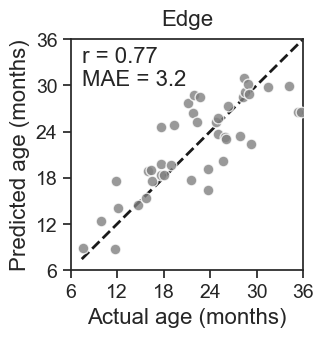

In [10]:
# Loop predictors and plot median model
all_predictor_dict = dict({
    'mean t12':{
        'title':'Mean T1w/T2w',
        'df':mean_t12_dev
    },
    'degree':{
        'title':'Degree',
        'df':degree_dev
    },
    'edge':{
        'title':'Edge',
        'df':edge_dev
    }
})

for predictor in list(all_predictor_dict.keys()):
    # Get index of median performance (partial R)
    predictor_best_performance = best_models_performance_df[best_models_performance_df['predictor'] == predictor].reset_index(drop=True)
    median_idx = (predictor_best_performance['partial_r'] - predictor_best_performance['partial_r'].median()).abs().idxmin()  

    # Get model params corresponding to this model
    predictor_all_performance = all_models_performance_df[all_models_performance_df['predictor'] == predictor].reset_index(drop=True)
    model_idx = predictor_all_performance.iloc[:,median_idx+6].idxmin()
    best_model = predictor_all_performance.iloc[model_idx, 0:6]
    
    # Get train/test indices for median fold
    train_index = outer_split_dict[median_idx]['train']
    test_index = outer_split_dict[median_idx]['test']

    # Re-train winning model
    df = all_predictor_dict[predictor]['df'].copy()
    X = df.iloc[:, 4:]
    y = df['Age']

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Scale data
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Fit model
    if best_model['model'] == 'SVR()':
        model = SVR(C=best_model['model__C'],
                    gamma=best_model['model__gamma'],
                    kernel=best_model['model__kernel'])
    elif best_model['model'] == 'GaussianProcessRegressor()':
        model = GaussianProcessRegressor(kernel=DotProduct() + WhiteKernel(noise_level_bounds=(1e-10, np.inf)))

    model.fit(X_train_scaled, y_train)

    # Visualise results
    # Predict on test data
    y_pred = model.predict(X_test_scaled)

    # Calculate MSE
    mae = mean_absolute_error(y_test, y_pred)

    # Calculate partial R
    eval_df = pd.DataFrame({
        'test':y_test,
        'pred':y_pred,
        'sex':covariate_dev.loc[test_index, 'Sex'],
        'etiv':covariate_dev.loc[test_index, 'etiv']
    })
    
    partial_r = pg.partial_corr(data=eval_df, 
                                x='test', 
                                y='pred', 
                                covar=['sex', 'etiv'], 
                                method='spearman').iloc[0,1]

    # Plot predicted vs actual
    plt.figure(figsize=(3, 3))
    ax = plt.scatter(y_test, y_pred, alpha=0.8, zorder=3, color='grey', edgecolor='white', s=60)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2, zorder=2)
    plt.xlabel('Actual age (months)', fontsize=16, fontfamily='Arial')
    plt.ylabel('Predicted age (months)', fontsize=16, fontfamily='Arial')
    plt.title(all_predictor_dict[predictor]['title'], fontsize=16, pad=10, fontfamily='Arial')
    x1, x2 = 0.5, 3; y1, y2 = 0.5, 3
    plt.xlim([x1,x2])
    plt.ylim([y1,y2])
    plt.text(x1+0.05*(x2-x1), y1+0.8*(y2-y1), f'r = {partial_r:.2f}\nMAE = {mae*12:.1f}', fontsize=16, fontfamily='Arial')
    
    ticks = plt.gca().get_yticks()
    plt.gca().set_xticklabels([f"{t * 12:.0f}" for t in ticks], fontsize=14)
    plt.gca().set_yticklabels([f"{t * 12:.0f}" for t in ticks], fontsize=14)
    plt.show()
